# Чётенькое такси

## Описание проекта

Компания "Чётенькое такси" предоставила нам данные о заказах такси в аэропортах за определенный период. Ведь не всегда получается угадать сколько водителей нужно подгототавливать каждый час, чтобы они могли быстро приехать в аэропорт за клиентом. Это поможет обойти конкурентов и увеличить прибыль. Поэтому компания обратилась за помощью к нам.

## Задача проекта

Разработать модель, определяющую по данным, которые предоставила компания, кол-во таксистов на каждый час, которых нужно отправить в аэропорт. Это значительно поможет уменьшить время ожидания клиентов , увеличив прибыль компании

## Описание данных

Компания предоставила информацию в виде таблицы Excel, состоящей всего из двух столбцов: datetime - время(интервал), во время которого происходило определенное кол-во заказов. num_orders - кол-во заказов в определенный промежуток времени

## Установка и импорт библиотек

In [1]:
!pip install pandas
!pip show numpy
!pip install -U scikit-learn

Name: numpy
Version: 1.21.1
Summary: NumPy is the fundamental package for array computing with Python.
Home-page: https://www.numpy.org
Author: Travis E. Oliphant et al.
Author-email: None
License: BSD
Location: /opt/conda/lib/python3.9/site-packages
Requires: 
Required-by: xgboost, transformers, thinc, tensorflow-cpu, tensorboard, statsmodels, spacy, seaborn, scipy, scikit-learn, pyod, pyarrow, patsy, pandas, opt-einsum, numba, matplotlib, lightgbm, Keras-Preprocessing, h5py, gensim, folium, catboost, blis


In [2]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from lightgbm import LGBMRegressor
from sklearn.model_selection import TimeSeriesSplit
plt.rcParams["figure.figsize"] = (10,5)

## Используемые функции

In [3]:
# функция создания признаков для обучения моделей и решения задачи временных рядов
def make_features(taxi, max_lag, rolling_mean_size):
    taxi['day'] = taxi.index.day
    taxi['dayofweek'] = taxi.index.dayofweek
    taxi['hour'] = taxi.index.hour
    
    for lag in range(1, max_lag + 1):
        taxi['lag_{}'.format(lag)] = taxi['num_orders'].shift(lag) # с помощью shift и цикла создаем новые переменные

    taxi['rolling_mean'] = taxi['num_orders'].shift().rolling(rolling_mean_size).mean() # создаем признак со скользящим среднем

## Загрузка данных

Считаем и посмотрим на файл, который нам предоставили. Сделаем сразу столбец datetime индексом для дальнейшего удобства работы, ресемплинг по каждому часу с суммой значений в этом промежутке, как просил заказсчик. И, на всякий случай, отсортируем индексы(время)

In [4]:
if os.path.exists('taxi.csv'):
    taxi = pd.read_csv('taxi.csv', index_col=[0], parse_dates=[0])
    taxi.sort_index(inplace=True)
    taxi = taxi.resample('1H').sum()
    display(taxi.head())
    print(taxi.shape)
    
elif os.path.exists('/datasets/taxi.csv'):
    taxi = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])
    taxi.sort_index(inplace=True)
    taxi = taxi.resample('1H').sum()
    display(taxi.head())
    print(taxi.shape)
    
else:
    print('File read error')

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


(4416, 1)


Всего 4416 записей и два столбца, как нам и сказали. На превый взгляд нет ничего особенного. Данные выглядят отлично

## Анализ данных

Теперь посмотрим на информацию о нашей таблице. Выведем общую информацию и кол-во пропусков. Дубликаты бессмысленно выводить, так как остается только один столбец.

In [5]:
display(taxi.info())
print()
print('Кол-во пропусков в таблице')
display(taxi.isna().sum())
print()
display(taxi.describe())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  4416 non-null   int64
dtypes: int64(1)
memory usage: 69.0 KB


None


Кол-во пропусков в таблице


num_orders    0
dtype: int64

,num_orders
count,4416.000000
mean,84.422781
std,45.023853
min,0.000000
25%,54.000000
50%,78.000000
75%,107.000000
max,462.000000


Тип данных не будем менять. Оставим int64. Пропусков не оказалось. 462 - максимальное кол-во заказов за час. Это достаточно много, но если посмотреть на среднее значение признака(84), то такое число можно посчитать  вполне реальным. Идем дальше

Теперь посмотрим на гистограмму и ящик с усами нашего единственного признака num_orders

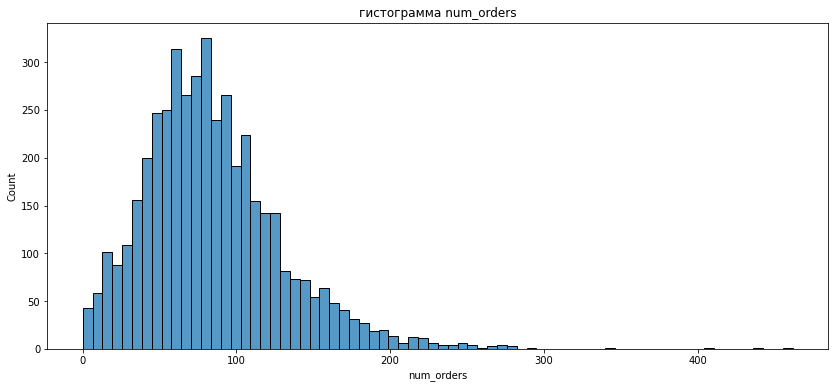

In [6]:
plt.figure(figsize = (14, 6))
plt.title('гистограмма num_orders')
sns.histplot(data = taxi, x = 'num_orders');

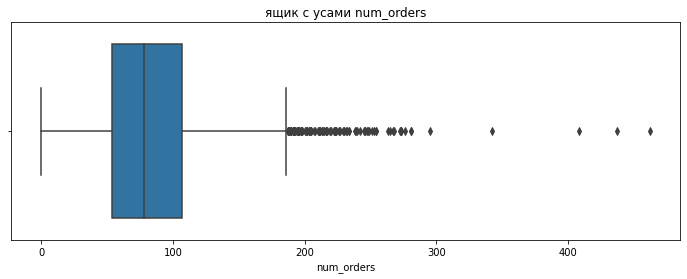

In [7]:
plt.figure(figsize = (12, 4))
plt.title('ящик с усами num_orders')
sns.boxplot(data = taxi, x = 'num_orders');

Гистограмма похожа на биноминальное распределение. Большая часть находится в промежутке от 30 до 130 человек. Есть значения, которые очень далеко ушли от всех. Они начинаются с 300. Их не стоит удалять, потому что нам нужно по условию заказсчика обучить модель на пиковые нагрузки тоже.

Построим график средних значений по кол-ву заказов по часам

In [8]:
taxi_g = taxi
taxi_g['mean']= taxi_g['num_orders'].shift().rolling(100).mean()

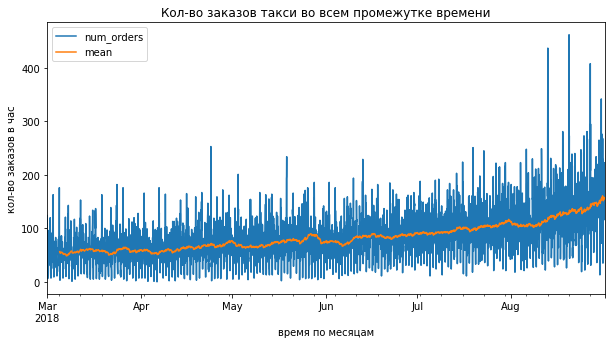

In [9]:
ax = taxi_g.plot()
ax.set_title("Кол-во заказов такси во всем промежутке времени")
ax.set_xlabel("время по месяцам")
ax.set_ylabel("кол-во заказов в час")
plt.show();

По графику можно заметить, что он нестационарный, потому что люди постепенно, начиная с матра заказывают все больше такси в аэропорт. В августе начинается заметный прирост, что достаточно логично. Люди начинают с лета активнее путешествовать, поэтому и больше заказов.  
По логике, заказы должны увеличиваться в выходные дни, так как люди улетают обычно на неделю или две в пт, сб или вс. Для этого посмотрим на заказы по дням

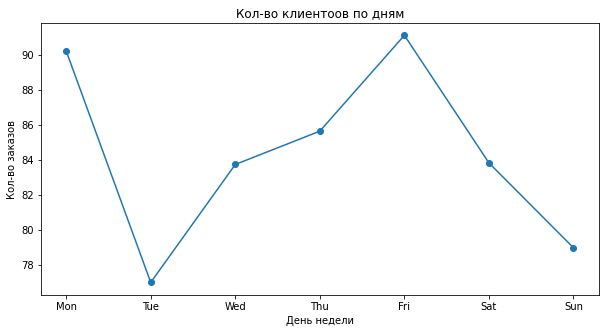

In [10]:
taxi_g['day_of_week'] = taxi_g.index.dayofweek
grouped = taxi_g.groupby('day_of_week').mean()
plt.figure(figsize=(10, 5))
plt.plot(grouped.index, grouped['num_orders'], marker='o')
plt.xticks(range(7), ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
plt.xlabel('День недели')
plt.ylabel('Кол-во заказов')
plt.title('Кол-во клиентоов по дням')
plt.show()

Чаще всего люды заказывали такси в понедельник и пятницу, а реже - во вторник и воскресенье

Посмотрим еще на сэмплирование по календарным дням, неделям и месяцам

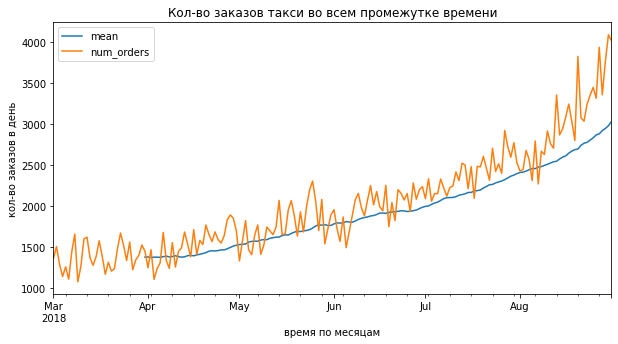

In [11]:
taxi_days = taxi
taxi_days = taxi_days.resample('1D').sum()
taxi_days = taxi_days.drop('mean', axis = 1)
taxi_days['mean']= taxi_days['num_orders'].shift().rolling(30).mean()
ax = taxi_days[['mean', 'num_orders']].plot()
ax.set_title("Кол-во заказов такси во всем промежутке времени")
ax.set_xlabel("время по месяцам")
ax.set_ylabel("кол-во заказов в день")
plt.show();

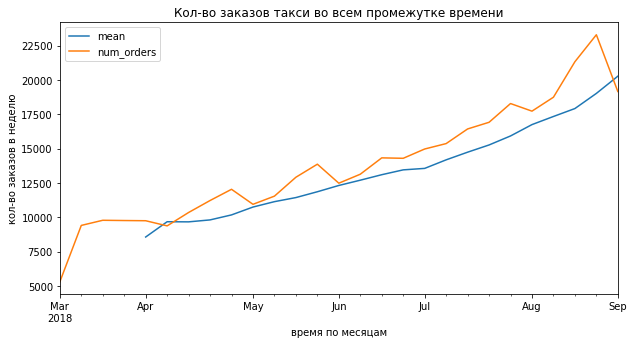

In [12]:
taxi_weekly = taxi_g.resample('W').sum()  # пересемплирование на недельный интервал
taxi_weekly['mean'] = taxi_weekly['num_orders'].shift().rolling(4).mean()  # расчет скользящего среднего для недельных значений
ax = taxi_weekly[['mean', 'num_orders']].plot()
ax.set_title("Кол-во заказов такси во всем промежутке времени")
ax.set_xlabel("время по месяцам")
ax.set_ylabel("кол-во заказов в неделю")
plt.show();

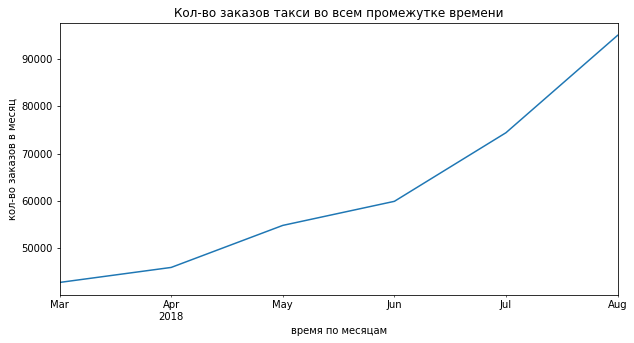

In [13]:
taxi_m = taxi
taxi_m = taxi_m.resample('1M').sum()
taxi_m['mean'] = taxi_m['num_orders'].mean()
taxi_m = taxi_m.drop('mean', axis = 1)
ax = taxi_m['num_orders'].plot();
ax.set_title("Кол-во заказов такси во всем промежутке времени")
ax.set_xlabel("время по месяцам")
ax.set_ylabel("кол-во заказов в месяц")
plt.show();

Из всех графиков на какую-то тенденцию больше всего похоже разбиение по часам, поэтому посмотрим на них внимательней. Для этого нужно взять отрезок из нескольких дней. Лучше взять плюс минус стабильный ну или где нет праздников, чтобы было честно

/tmp/ipykernel_503/1802373341.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  taxi_g['mean_1']= taxi_g['num_orders'].shift().rolling(10).mean()


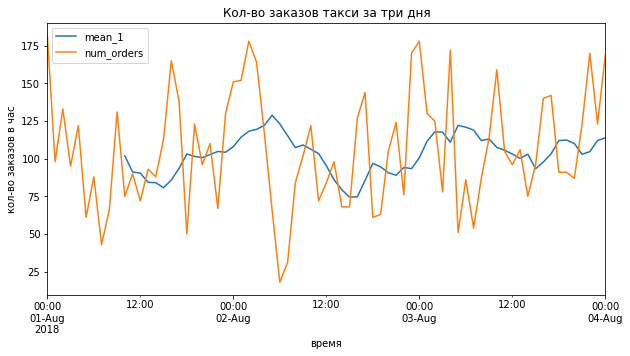

In [14]:
taxi_g = taxi_g.loc['2018-08-01 00:00:00':'2018-08-04 00:00:00']
taxi_g['mean_1']= taxi_g['num_orders'].shift().rolling(10).mean()
fig, ax = plt.subplots()
taxi_g[['mean_1', 'num_orders']].plot(ax=ax)
ax.set_title("Кол-во заказов такси за три дня")
ax.set_xlabel("время")
ax.set_ylabel("кол-во заказов в час")
plt.show();

Можно заметить, что около 00 и 14 часов происходит больше всего заказов. А часов в 7 утра их меньше всего

Отлично! На данном этапе мы провели анализ данных, то есть всего одного признака, так как столбец со временем мы индексировали.  С помощью графиков посмотрели на временные ряды по месяцам, неделям, дням и часам. rolling помог усреднить значения, чтобы было видно тенденцию роста графиков. В итоге мы определили сезонность при рассотрении часов, узнали, что летом достаточно сильно увеличивается спрос на такси, что достаточно логично и около 00 и 14 часов пики заказов, а в 7 наоборот - спад. Ряд сэмплирования по часам оказался нестационарным
Пропусков не оказалось. Проверять на корреляцию признаки нет смысла, масштабировать их тоже не нужно. Можно приступать к обучению и построению моделей

## Обучение моделей

Перед нами оказалась задача на временные ряды. У нее обычно мало признаков, а для обучения моделям их нужно больше. Поэтому будем создавать эти признаки сами.

In [15]:
TEST_SIZE = 0.1
RANDOM_STATE = 42
best_rmse_1 = 100
params = [1, 3, 5, 7, 10]
param_grid = {}
for i in params:
    for j in params:
        make_features(taxi, i, j)
        rmse_1 = 0
        X = taxi.drop('num_orders', axis=1)
        y = taxi['num_orders']
        q = len(X)
        X = X.dropna()
        w = len(X)
        y = y[q - w:]
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE)

        model = LinearRegression()

        gs = GridSearchCV(model, param_grid, scoring='neg_mean_squared_error', cv=5)
        gs.fit(X_train, y_train)
        predictions = gs.predict(X_train)
        best_rmse_1 = (-gs.best_score_)**0.5
        print(f'max_lag = {i}')
        print(f'rolling_mean_size = {j}')
        print(best_rmse_1)
        print()

max_lag = 1
rolling_mean_size = 1
33.476974418493626

max_lag = 1
rolling_mean_size = 3
33.46411222781482

max_lag = 1
rolling_mean_size = 5
33.3518711224814

max_lag = 1
rolling_mean_size = 7
33.390914442509086

max_lag = 1
rolling_mean_size = 10
33.390107711315366

max_lag = 3
rolling_mean_size = 1
33.26176752512944

max_lag = 3
rolling_mean_size = 3
33.265531882102835

max_lag = 3
rolling_mean_size = 5
33.175890346633935

max_lag = 3
rolling_mean_size = 7
33.225768063033556

max_lag = 3
rolling_mean_size = 10
33.207222614306176

max_lag = 5
rolling_mean_size = 1
33.186823474652854

max_lag = 5
rolling_mean_size = 3
33.184246864521256

max_lag = 5
rolling_mean_size = 5
33.18381553114664

max_lag = 5
rolling_mean_size = 7
33.182692376606894

max_lag = 5
rolling_mean_size = 10
33.17337823748216

max_lag = 7
rolling_mean_size = 1
33.15328369459394

max_lag = 7
rolling_mean_size = 3
33.15328369459394

max_lag = 7
rolling_mean_size = 5
33.15328871058447

max_lag = 7
rolling_mean_size = 7


Лучшая метрика RMSE = 33 при таких параметрах: max_lag = 10, rilling_mean_size = 1. Очень хорошая метрика. Посмторим, что покажут другие модели

При различных параметрах изменений в метриках особо нет. Но с такими параметрами: max_lag = 10 и rolling_mean_size = 1 получилась такая метрика: RMSE 33. Это лучшие значения из всех. Обучим еще одну модель-DecisionTreeRegressor. Для начала найдем параметры признаков, а только потом с помощью GridSearch передем параметры дерева, чтобы улучшить результат. Делаем это раздельно, чтобы не было двух вложенных циклов, в которых будет еще и перебор параметров гридсерча.

In [16]:
for i in params:
    for j in params:
        make_features(taxi, i, j)
        X = taxi.drop('num_orders', axis=1)
        y = taxi['num_orders']
        q = len(X)
        X = X.dropna()
        w = len(X)
        y = y[q - w:]
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE)

        model = DecisionTreeRegressor(random_state = RANDOM_STATE)
        gs = GridSearchCV(model, param_grid, scoring='neg_mean_squared_error', cv = 5)
        gs.fit(X_train, y_train)
        predictions = gs.predict(X_train)
        best_rmse_2 = (-gs.best_score_)**0.5
        print(f'max_lag = {i}')
        print(f'rolling_mean_size = {j}')
        print(best_rmse_2)
        print()
    

max_lag = 1
rolling_mean_size = 1
35.5232668322244

max_lag = 1
rolling_mean_size = 3
35.56507614825008

max_lag = 1
rolling_mean_size = 5
35.71009892268385

max_lag = 1
rolling_mean_size = 7
35.673605283451735

max_lag = 1
rolling_mean_size = 10
35.96341347570588

max_lag = 3
rolling_mean_size = 1
35.5232668322244

max_lag = 3
rolling_mean_size = 3
35.56507614825008

max_lag = 3
rolling_mean_size = 5
35.71009892268385

max_lag = 3
rolling_mean_size = 7
35.673605283451735

max_lag = 3
rolling_mean_size = 10
35.96341347570588

max_lag = 5
rolling_mean_size = 1
35.5232668322244

max_lag = 5
rolling_mean_size = 3
35.56507614825008

max_lag = 5
rolling_mean_size = 5
35.71009892268385

max_lag = 5
rolling_mean_size = 7
35.673605283451735

max_lag = 5
rolling_mean_size = 10
35.96341347570588

max_lag = 7
rolling_mean_size = 1
35.5232668322244

max_lag = 7
rolling_mean_size = 3
35.56507614825008

max_lag = 7
rolling_mean_size = 5
35.71009892268385

max_lag = 7
rolling_mean_size = 7
35.6736052

Лучшими параметрами оказались: max_lag = 10 и rolling_mean_size = 1. Тестовая метрика получилась: 35.52. Это больше линейной регрессии, но тоже удовлетворяет условиям заказсчика. Можно попытаться сделать метрику еще меньше, обучив другую модель, либо, подобрав еще параметры для дерева с помощью гридсерча. Начнем как раз с этого.

In [17]:
param_grid = {
    'max_depth': [1, 3, 6, None],
    'min_samples_split': [10, 30, 70],
    'min_samples_leaf': [5, 15, 100]
}

In [18]:
make_features(taxi, 10,  1)

In [19]:
X = taxi.drop('num_orders', axis=1)
y = taxi['num_orders']
q = len(X)
X = X.dropna()
w = len(X)
y = y[q - w:]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE)
model = DecisionTreeRegressor(random_state = RANDOM_STATE)
gs = GridSearchCV(model, param_grid, scoring='neg_mean_squared_error', cv = 5)
gs.fit(X_train, y_train)
predictions = gs.predict(X_train)
best_rmse_2 = (-gs.best_score_)**0.5
print(f'max_lag = {10}')
print(f'rolling_mean_size = {1}')
print(best_rmse_2)
best_model = gs.best_estimator_
print(best_model)

max_lag = 10
rolling_mean_size = 1
28.120834919260275
DecisionTreeRegressor(min_samples_leaf=5, min_samples_split=70, random_state=42)


Метрика улучшилась практически на 10 и стала равна 28. Это уже лучше первой модели, но можно проверить еще одну - градиентный бустинг. Возможно, он покажет себя лучше всех

Проверим последнюю модель - LGBMRegressor

In [20]:
param_grid = {}
params = [1, 3, 5, 7, 10]
for i in params:
    for j in params:
        make_features(taxi, i, j)
        X = taxi.drop('num_orders', axis=1)
        y = taxi['num_orders']
        q = len(X)
        X = X.dropna()
        w = len(X)
        y = y[q - w:]
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE)

        model = LGBMRegressor(seed=RANDOM_STATE, verbosity=-1)
        
        gs = GridSearchCV(model, param_grid, scoring='neg_mean_squared_error', cv = 5)
        gs.fit(X_train, y_train)
        predictions = gs.predict(X_train)
        best_rmse_3 = (-gs.best_score_)**0.5
        print(f'max_lag = {i}')
        print(f'rolling_mean_size = {j}')
        print(best_rmse_3)
        print()


max_lag = 1
rolling_mean_size = 1
24.69025112981686

max_lag = 1
rolling_mean_size = 3
24.840367393523096

max_lag = 1
rolling_mean_size = 5
24.935435755873783

max_lag = 1
rolling_mean_size = 7
24.702913656334708

max_lag = 1
rolling_mean_size = 10
24.724967179104596

max_lag = 3
rolling_mean_size = 1
24.69025112981686

max_lag = 3
rolling_mean_size = 3
24.840367393523096

max_lag = 3
rolling_mean_size = 5
24.935435755873783

max_lag = 3
rolling_mean_size = 7
24.702913656334708

max_lag = 3
rolling_mean_size = 10
24.724967179104596

max_lag = 5
rolling_mean_size = 1
24.69025112981686

max_lag = 5
rolling_mean_size = 3
24.840367393523096

max_lag = 5
rolling_mean_size = 5
24.935435755873783

max_lag = 5
rolling_mean_size = 7
24.702913656334708

max_lag = 5
rolling_mean_size = 10
24.724967179104596

max_lag = 7
rolling_mean_size = 1
24.69025112981686

max_lag = 7
rolling_mean_size = 3
24.840367393523096

max_lag = 7
rolling_mean_size = 5
24.935435755873783

max_lag = 7
rolling_mean_size

Лучшие параметры max_lag = 10 и rolling_mean_size = 1. RMSE на трен выборке - 24.69. Выберем гиперпараметры для модельки

In [21]:
model = LGBMRegressor(seed=RANDOM_STATE, verbosity=-1)
param_grid = {
    'n_estimators': [10, 50, 100],
    'max_depth': [5, 20, 50]
}

make_features(taxi, 10,  1)
X = taxi.drop('num_orders', axis=1)
y = taxi['num_orders']
q = len(X)
X = X.dropna()
w = len(X)
y = y[q - w:]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE)

gs = GridSearchCV(model, param_grid, scoring='neg_mean_squared_error', cv = 5)
gs.fit(X_train, y_train)
predictions = gs.predict(X_train)
best_rmse_3 = (-gs.best_score_)**0.5
print(f'max_lag = {10}')
print(f'rolling_mean_size = {1}')
print(best_rmse_3)
best_model = gs.best_estimator_
print(best_model)

max_lag = 10
rolling_mean_size = 1
24.540774243750732
LGBMRegressor(max_depth=20, n_estimators=50, seed=42, verbosity=-1)


Итоговая метрика для градиентного бустинга с гиперпараметрами max_depth=20, n_estimators=50, seed=42, verbosity=-1 оказалась 24.54. Практически ничего не изменилось после перебора гиперпараметров

In [22]:
w = ['модель', 'метрика RMSE']
q = [['LinearRegressoin', best_rmse_1], ['DecisionTreeRegressor', best_rmse_2], ['LGBMRegressor', best_rmse_3],]
itogi = pd.DataFrame(data = q, columns = w)
itogi

,модель,метрика RMSE
0,LinearRegressoin,33.030798
1,DecisionTreeRegressor,28.120835
2,LGBMRegressor,24.540774


Лучшая метрика у модели LGMRegression - 24. Она дольше всех обучается, но это не критично. Проверим градиентный бустинг на тестовой выборке

In [24]:
model = LGBMRegressor(seed=RANDOM_STATE, verbosity=-1)
param_grid = {
    'n_estimators': [50],
    'max_depth': [20]
}

make_features(taxi, 10,  1)
X = taxi.drop('num_orders', axis=1)
y = taxi['num_orders']
q = len(X)
X = X.dropna()
w = len(X)
y = y[q - w:]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE)

model.fit(X_train, y_train)
predictions = model.predict(X_test)
rmse_model = mean_squared_error(y_test, predictions, squared=False)
print('rmse_model', rmse_model)
print(f'max_lag = {10}')
print(f'rolling_mean_size = {1}')

rmse_model 22.897395115258227
max_lag = 10
rolling_mean_size = 1


/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Итоговая метрика на тестовой выборке оказалась равна 22.9. Это еще лучше, чем при обучении на кросс-валидации

Можно подвести итог данного шага. Лучшей моделью оказался градиентный бустинг LGBMRegressor, который дал конечную метрику на тренировочной RMSE = 24, а на тестовой - 23 с гиперпараметрами. Это все удовлетворяет запросам заказсчика.  
Следующей моделью по наименьшей метрике оказалось DecisionTreeRegressor с метрикой RMSE = 28. И хуже всех показала себя модель линейной регрессии. Ее метрика 33.

## Итоги проекта

У нас получилось подобрать и обучить лучшую модель для предсказания количества клиентов на ближайшие часы, которые вызовут такси в аэропорт по прилете. Для этого мы разбили проект на шаги:  
* Загрузка данных. На данном шаге мы просто загрузили данные, отсортировав и убрав признак даты в индекс, и посмотрели на их объем, названия признаков и их качество заполнения.
* Анализ данных. Из-за маленького количества признаков этап получился коротким. Пропусков не было, дубликатов тоже.
* Обучение моделей. Финальный шаг, ради которого был проделан весь прошлый путь. На нем мы обучили три различных вида моделей регрессии. Это была: линейная регрессия, дерево решений и градиентный бустинг. По порядку результаты метрики получились такими: 33, 28, 24. Из них все модели удовлетворили условию заказсчика.

Итоговой лучшей моделью на тестовой выборке оказался градиентный бустинг с метрикой RMSE = 22.9, с наименьшей метрикой на тестовой выборке. Дерево решений получилось тоже хорошей моделью, но чуть хуже метрикой, зато немного быстрее выдает результат.